# Dev notebook for updates

`No development at the moment`

In [13]:
import numpy as np
from dmrg.MPS import MPS 
from dmrg.MPO import MPO_TFI
# from dmrg.cont import CONT
from dmrg.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt

### Class 

In [14]:
import os
import shutil
import numpy as np

class CONT():
    """
    Class that manages and stores in the memory the contractions on a 1 dimnasional MPS:
        Attributes:
            - mps: mps in the class DMRG.MPS
            - H: MPO of the hamiltonian of the class mpo_etc
            - mem: memory option if turned off the contraction are saved in a list (inconvinient and occupies a lot of memory)
            - path: folder path were the contractions are saved
    """

    # dictionary for the direction of the contraction
    dir = {'l':'/LEFT','r':'/RIGHT'}
    count = {'l':0,'r':1}


    def __init__(self,mps,H,mem='on',path='CONT'):
        self.mps = mps
        self.h = H 
        self.L = mps.L
        # build folder structure were tensors are saved
        if mem == 'on':
            self.path = path
            if os.path.isdir(path):
                shutil.rmtree(path)
            os.mkdir(path)
            os.mkdir(path+'/LEFT')
            os.mkdir(path+'/RIGHT')
            for i in range(mps.L - 3):
                open(path+f'/LEFT/cont_{i}.dat','w')
                open(path+f'/RIGHT/cont_{mps.L-i-1}.dat','w')
            
            self.write_boundary()

        if mem == 'off':
            self.LEFT = []
            self.RIGHT = []
            
    # @classmethod

    def write(self,site,ten,dir):
        if dir != 'l' and dir != 'r':
            raise ValueError('the direction needs to be either l or r !!!')

        tenmap = np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='w+',shape=ten.shape)
        tenmap[:] = ten
        with open(self.path+self.dir[dir]+f'/cont_{site}.txt','w') as f:
            f.writelines(repr(ten.shape))
        del tenmap,f

    def shape(self,site,dir):
        s = open(self.path+self.dir[dir]+f'/cont_{site}.txt','r')
        return eval(s.read())

    def read(self,site,dir):
        return np.memmap(self.path+self.dir[dir]+f'/cont_{site}.dat',dtype='complex',mode='r',shape=self.shape(site,dir))

    def add(self,site,dir):
        ten = self.read(site-(-1)**self.count[dir],dir)
        # ten = self.read(site,dir)

        ten = np.tensordot(ten,self.mps.read(site),(0,1+self.count[dir]))
        ten = np.tensordot(ten,self.h.mpo(p=site),([0,2],[2+self.count[dir],0]))
        ten = np.tensordot(ten,np.conj(self.mps.read(site)),([0,2],[1+self.count[dir],0]))

        self.write(site,ten,dir)
        return ten

    def left(self,site):
        """ 
        Contract all the tensors left of site including it 
        """
        h = self.h
        np.tensordot(self.mps.read(0),h.Wl(),(0,0))
        res = np.tensordot(np.tensordot(self.mps.read(0),h.Wl(),(0,0)),np.conj(self.mps.read(0)),(1,0))
        for i in range(1,site+1):
            res = np.tensordot(res,self.mps.read(i),(0,1))
            res = np.tensordot(res,h.mpo(p=i),([0,2],[2,0]))
            res = np.tensordot(res,np.conj(self.mps.read(i)),([0,2],[1,0]))

        return res
    
    def right(self,site):
        """
        Contract all the tensors right of site including it
        """
        h = self.h
        res = np.tensordot(np.tensordot(self.mps.read(self.L-1),h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
        for i in range(1,self.L-site):
            res = np.tensordot(res,self.mps.read(self.L-1-i),(0,2))
            res = np.tensordot(res,h.mpo(p=i),([0,2],[3,0]))
            res = np.tensordot(res,np.conj(self.mps.read(self.L-1-i)),([0,2],[2,0]))
        
        return res

    def write_boundary(self):

        for i in range(self.L%2+1):
            ten_l = self.left(i)
            self.write(i,ten_l,'l')

        ten_r = np.tensordot(np.tensordot(self.mps.read(self.L-1),self.h.Wr(),(0,0)),np.conj(self.mps.read(self.L-1)),(1,0))
        self.write(self.L-1,ten_r,'r')
    
    
    
    def env_prep(self,site):
        
        return self.read(site - 1,'l'),self.read(site + 2,'r')

    def random(self):
        for i in range(1,self.L//2):
            self.add(i+self.L%2,'l')
            self.add(self.mps.L-i-1,'r')

In [15]:
class MPO_AL():

    Id2 = np.identity(2)
    Id4 = np.identity(4)
    Sp = np.array([[0,1],[0,0]])
    Sm = np.array([[0,0],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    d = 4

    sub_BC = [0,2,3]
    sub_A = [1,4]

    def __init__(self,t_1,t_2,U,e_A,mu):
        self.t_1 = t_1
        self.t_2 = t_2
        self.U = U
        self.e_A = e_A
        self.mu = mu
        self.OP = [np.kron(MPO_AL.Sm,MPO_AL.Id2),np.kron(MPO_AL.Sp,MPO_AL.Id2),np.kron(MPO_AL.Z,MPO_AL.Sm),np.kron(MPO_AL.Z,MPO_AL.Sp)]
        self.coeff = [[self.t_1,self.t_2,self.t_2,0,0],
                    [self.t_1,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_1,self.t_2,0,self.t_2],
                    [0,self.t_1,0,0,self.t_2]]

    
    def mpo(self,p=None):

        MPO = np.zeros((4,4,22,22))

        MPO[:,:,0,0] = MPO_AL.Id4
        MPO[:,:,0,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        MPO[:,:,0,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        MPO[:,:,0,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        MPO[:,:,0,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        MPO[:,:,0,21] = -self.mu*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        # sublattice conditions
        if (p-1)%5 in MPO_AL.sub_BC:
            MPO[:,:,0,21] += self.U*np.kron(MPO_AL.Z,MPO_AL.Z)
        
        if (p-1)%5 in MPO_AL.sub_A:
            MPO[:,:,0,21] += self.e_A*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        for j in range(4):
            for i in range(4):
                MPO[:,:,1 +j*5 +i,2+j*5+i] = np.kron(MPO_AL.Z,MPO_AL.Z)

        
        for j in range(1,6):
            for i in range(4):
                MPO[:,:,j+5*i,21] = self.coeff[(p-1)%5][j-1]*self.OP[i]

        MPO[:,:,21,21] = MPO_AL.Id4

        return MPO

    def Wl(self):

        Wleft = np.zeros((4,4,22))

        Wleft[:,:,0] = MPO_AL.Id4
        Wleft[:,:,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        Wleft[:,:,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        Wleft[:,:,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        Wleft[:,:,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        Wleft[:,:,21] = (-self.mu + self.e_A )*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z)) 

        return Wleft

    def Wr(self):

        Wright = np.zeros((4,4,22))

        for j in range(1,6):
            for i in range(4):
                Wright[:,:,j+5*i] = self.coeff[1][j-1]*self.OP[i]

        Wright[:,:,21] = MPO_AL.Id4

        return Wright

### Test

In [ ]:
L = 18
mps = MPS(L,d=4)
h = MPO_AL(.1,1,1,1,1)
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
mps.random()
cont.random()


sys.chi = 100
EE = []
EE_pre = []
k = 0 


for site,dir in mps.first_sweep():
    # print(site)
    En,_ = sys.step2sites(site,dir=dir)
    # EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

Z = []
for i in range(2,L-2):
    if i == 2:
        o1,o2 = obs.bound_left(i-1,np.kron(h.Z,h.Z))
        Z += [o1.real,o2.real]
    En_fin,_ =sys.step2sites(i,dir='r',stage='Final')
    EE.append(En)
    Z += [obs.single_site(i,np.kron(h.Z,h.Z)).real]
    if i == L-3:
        o1,o2 = obs.bound_right(i+1,np.kron(h.Z,h.Z))
        Z += [o1.real,o2.real]

plt.plot(EE[1:])

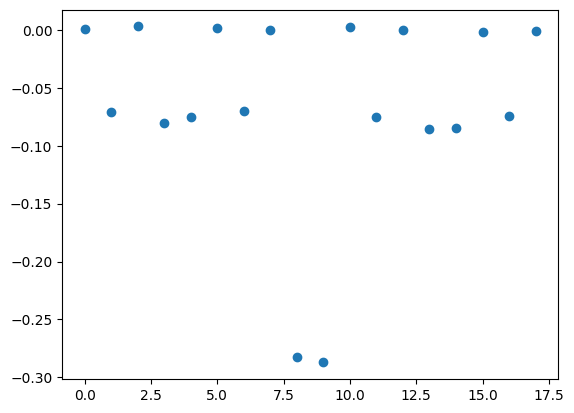

In [11]:
plt.plot(Z,'o')

In [ ]:
from itertools import product
dim = [4,2,2]
Id4 = np.identity(4)
res = np.zeros((2,2,4))
ranges = [range(d) for d in dim]
for i in product(*ranges):
    res[i[0],i[1],i[2]] =Id4[i[0]i[1]i[2]]

In [ ]:
d=4
a = np.reshape(np.identity(d**2)[:,:d],(d,d,d))
np.tensordot(a,a,((0,1),(0,1)))